In [ ]:
import pandas as pd
import numpy as np

df = pd.read_json("/home/yszhou/multilingual_project/experiment/analysis/full_result/combined_output_v4.jsonl", lines=True)
columns_to_keep = [
    "benchmark", "is_correct", "model", "pred_label", "ground_truth", 
    "prompt_lang", "question_lang", "prompt_id", "question_id"
]
filtered_df = df[columns_to_keep]
filtered_df.to_json("combined_output_simple.jsonl", orient="records", lines=True, force_ascii=False)

In [ ]:
import pandas as pd
import numpy as np

df_with_len = pd.read_json("/home/yszhou/multilingual_project/experiment/analysis/output_with_len.jsonl", lines=True)
columns_to_keep_2 = [
    "benchmark", "is_correct", "model", "pred_label", "ground_truth", 
    "prompt_lang", "question_lang", "prompt_id", "question_id", "output_len"
]
filtered_df_with_len = df_with_len[columns_to_keep_2]
filtered_df_with_len.to_json("combined_output_simple_with_len.jsonl", orient="records", lines=True, force_ascii=False)

In [ ]:
#对pred_label进行标准化，用于计算熵值
import pandas as pd
import numpy as np
from math import log

def normalize_label(row):
    label = str(row["pred_label"]).strip()
    benchmark = row["benchmark"]

    if benchmark == "ethics":
        return label if label in ["0", "1"] else "invalid"
    elif benchmark == "mmlupro":
        return label if label in list("ABCDEFGHIJ") else "invalid"
    else:
        return "invalid" 

filtered_df_with_len["standard_label"] = filtered_df_with_len.apply(normalize_label, axis=1)

In [ ]:
#计算熵值并求均值
def compute_normalized_entropy(labels):
    value_counts = pd.Series(labels).value_counts(normalize=True)
    entropy = -np.sum(value_counts * np.log(value_counts + 1e-10))  
    max_entropy = log(5)  
    return entropy / max_entropy if max_entropy > 0 else 0

grouped_entropy = (
    filtered_df_with_len.groupby(["benchmark", "model", "prompt_id", "question_id"])["standard_label"]
    .apply(compute_normalized_entropy)
    .reset_index()
    .rename(columns={"standard_label": "normalized_entropy"})
)

prompt_entropy_summary = (
    grouped_entropy.groupby(["benchmark", "model", "prompt_id"])["normalized_entropy"]
    .mean()
    .reset_index()
    .rename(columns={"normalized_entropy": "mean_entropy"})
)
grouped_mmlupro_entropy = prompt_entropy_summary[prompt_entropy_summary["benchmark"] == "mmlupro"]
grouped_mmlupro_entropy["mean_entropy"] = 1 - grouped_mmlupro_entropy["mean_entropy"]
grouped_mmlupro_entropy

In [9]:
#计算joingt probability
def is_all_equal(labels):
    unique_labels = set(labels)
    return 1 if len(unique_labels) == 1 else 0

grouped_consistency = (
    filtered_df_with_len.groupby(["benchmark", "model", "prompt_id", "question_id"])["pred_label"]
    .apply(is_all_equal)
    .reset_index()
    .rename(columns={"pred_label": "all_equal_consistency"})
)

prompt_consistency_summary = (
    grouped_consistency.groupby(["benchmark", "model", "prompt_id"])["all_equal_consistency"]
    .mean()
    .reset_index()
    .rename(columns={"all_equal_consistency": "joint_probability"})
)
grouped_mmlupro_consistency = prompt_consistency_summary[prompt_consistency_summary["benchmark"] == "mmlupro"]
grouped_mmlupro_consistency

,benchmark,model,prompt_id,joint_probability
3000,mmlupro,Gemma-3-12B-Instruct,p_0,0.33
3001,mmlupro,Gemma-3-12B-Instruct,p_1,0.27
3002,mmlupro,Gemma-3-12B-Instruct,p_10,0.22
3003,mmlupro,Gemma-3-12B-Instruct,p_100,0.29
3004,mmlupro,Gemma-3-12B-Instruct,p_101,0.41
...,...,...,...,...
5995,mmlupro,Qwen2.5-7B-Instruct,p_995,0.16
5996,mmlupro,Qwen2.5-7B-Instruct,p_996,0.17
5997,mmlupro,Qwen2.5-7B-Instruct,p_997,0.00
5998,mmlupro,Qwen2.5-7B-Instruct,p_998,0.19


In [139]:
#计算每个prompt对于每个question在不同语言上的len的var
df2_len = df_with_len.groupby(["benchmark", "prompt_id", "question_id", "model"]).agg(
    output_tokens_var=("output_len", "var")
).reset_index()
df2_len = df2_len.groupby(["benchmark", "prompt_id", "model"]).mean(numeric_only=True).reset_index()
df2_len_mmlupro = df2_len[df2_len["benchmark"] == "mmlupro"]
df2_len

,benchmark,prompt_id,model,output_tokens_var
0,ethics,p_0,Gemma-3-12B-Instruct,187925.647000
1,ethics,p_0,Llama-3.1-8B-Instruct,95331.040000
2,ethics,p_0,Qwen2.5-7B-Instruct,193025.355167
3,ethics,p_1,Gemma-3-12B-Instruct,25447.864000
4,ethics,p_1,Llama-3.1-8B-Instruct,108342.895000
...,...,...,...,...
5995,mmlupro,p_998,Llama-3.1-8B-Instruct,598271.986000
5996,mmlupro,p_998,Qwen2.5-7B-Instruct,152382.173667
5997,mmlupro,p_999,Gemma-3-12B-Instruct,67879.231833
5998,mmlupro,p_999,Llama-3.1-8B-Instruct,910869.497000


In [124]:
#计算每个prompt的avgacc和var
df2 = df_with_len.groupby(["benchmark", "prompt_id", "prompt_lang", "model"]).mean(numeric_only=True).reset_index()
grouped = df2.groupby(["benchmark", "model", "prompt_id"]).agg(
    mean=("is_correct", "mean"),
    var=("is_correct", "var"),
    output_tokens_mean=("output_len", "mean"),
).reset_index()
grouped_mmlupro = grouped[grouped["benchmark"] == "mmlupro"]
grouped_ethics = grouped[grouped["benchmark"] == "ethics"]
grouped_mmlupro

,benchmark,model,prompt_id,mean,var,output_tokens_mean
3000,mmlupro,Gemma-3-12B-Instruct,p_0,0.505250,0.003163,1681.851250
3001,mmlupro,Gemma-3-12B-Instruct,p_1,0.532333,0.020569,504.524167
3002,mmlupro,Gemma-3-12B-Instruct,p_10,0.532750,0.011613,1104.241500
3003,mmlupro,Gemma-3-12B-Instruct,p_100,0.503250,0.004459,914.159083
3004,mmlupro,Gemma-3-12B-Instruct,p_101,0.573583,0.006960,697.781667
...,...,...,...,...,...,...
5995,mmlupro,Qwen2.5-7B-Instruct,p_995,0.339474,0.004938,292.839368
5996,mmlupro,Qwen2.5-7B-Instruct,p_996,0.452421,0.009758,510.015053
5997,mmlupro,Qwen2.5-7B-Instruct,p_997,0.233263,0.010224,1496.403158
5998,mmlupro,Qwen2.5-7B-Instruct,p_998,0.450526,0.015701,303.389158


In [147]:
# 加入baseline的结果
df_baseline = pd.read_json("/home/yszhou/multilingual_project/experiment/analysis/output_with_len_baseline.jsonl", lines=True)
df_baseline["standard_label"] = df_baseline.apply(normalize_label, axis=1)

grouped_consistency_baseline = (
    df_baseline.groupby(["benchmark", "model", "prompt_id", "question_id"])["pred_label"]
    .apply(is_all_equal)
    .reset_index()
    .rename(columns={"pred_label": "all_equal_consistency"})
)

prompt_consistency_summary_baseline = (
    grouped_consistency_baseline.groupby(["benchmark", "model", "prompt_id"])["all_equal_consistency"]
    .mean()
    .reset_index()
    .rename(columns={"all_equal_consistency": "joint_probability"})
)
grouped_mmlupro_consistency_baseline = prompt_consistency_summary_baseline[prompt_consistency_summary_baseline["benchmark"] == "mmlupro"]
grouped_ethics_consistency_baseline = prompt_consistency_summary_baseline[prompt_consistency_summary_baseline["benchmark"] == "ethics"]


df_baseline = df_baseline.groupby(["benchmark", "prompt_id", "prompt_lang", "model"]).mean(numeric_only=True).reset_index()

grouped_baseline = df_baseline.groupby(["benchmark", "model", "prompt_id"]).agg(
    mean=("is_correct", "mean"),
    var=("is_correct", "var"),
    output_tokens_mean=("output_len", "mean")
).reset_index()

grouped_mmlupro_baseline = grouped_baseline[grouped_baseline["benchmark"] == "mmlupro"]
grouped_ethics_baseline = grouped_baseline[grouped_baseline["benchmark"] == "ethics"]

grouped_mmlupro_baseline = grouped_mmlupro_baseline.merge(
    grouped_mmlupro_consistency_baseline,
    on=["benchmark", "model", "prompt_id"],
    how="left"
)

grouped_ethics_baseline = grouped_ethics_baseline.merge(
    grouped_ethics_consistency_baseline,
    on=["benchmark", "model", "prompt_id"],
    how="left"
)


In [148]:
#处理baseline的len的var
df_baseline_temp = pd.read_json("/home/yszhou/multilingual_project/experiment/analysis/output_with_len_baseline.jsonl", lines=True)
df2_len_baseline = df_baseline_temp.groupby(["benchmark", "prompt_id", "question_id", "model"]).agg(
    output_tokens_var=("output_len", "var")
).reset_index()
df2_len_baseline = df2_len_baseline.groupby(["benchmark", "prompt_id", "model"]).mean(numeric_only=True).reset_index()
df2_len_mmlupro_baseline = df2_len_baseline[df2_len_baseline["benchmark"] == "mmlupro"]
df2_len_mmlupro_baseline

grouped_mmlupro_baseline = grouped_mmlupro_baseline.merge(
    df2_len_mmlupro_baseline,
    on=["benchmark", "model", "prompt_id"],
    how="left"
)
grouped_mmlupro_baseline

,benchmark,model,prompt_id,mean,var,output_tokens_mean,joint_probability,output_tokens_var
0,mmlupro,Gemma-3-12B-Instruct,p_1000,0.537684,0.015445,403.079053,0.25,193751.265833
1,mmlupro,Gemma-3-12B-Instruct,p_1001,0.563789,0.010722,670.376632,0.33,146014.275667
2,mmlupro,Llama-3.1-8B-Instruct,p_1000,0.333180,0.005760,203.342469,0.17,532782.251500
3,mmlupro,Llama-3.1-8B-Instruct,p_1001,0.373180,0.010992,419.438548,0.13,710107.134833
4,mmlupro,Qwen2.5-7B-Instruct,p_1000,0.444421,0.014227,248.258211,0.16,90423.746333
5,mmlupro,Qwen2.5-7B-Instruct,p_1001,0.493579,0.023611,399.515895,0.14,123718.472333


In [ ]:
#加入math的结果
import pandas as pd
import numpy as np

df_math = pd.read_json("/home/yszhou/multilingual_project/experiment/analysis/output_with_len_add.jsonl", lines=True)
columns_to_keep_2 = [
    "benchmark", "is_correct", "model", "pred_label", "ground_truth", 
    "prompt_lang", "question_lang", "prompt_id", "question_id", "output_len"
]

filtered_df_math = df_math[columns_to_keep_2]
filtered_df_math.to_json("combined_output_simple_math.jsonl", orient="records", lines=True, force_ascii=False)


In [122]:
# 处理math的结果
grouped_consistency_math = (
    filtered_df_math.groupby(["benchmark", "model", "prompt_id", "question_id"])["pred_label"]
    .apply(is_all_equal)
    .reset_index()
    .rename(columns={"pred_label": "all_equal_consistency"})
)

prompt_consistency_summary_math = (
    grouped_consistency_math.groupby(["benchmark", "model", "prompt_id"])["all_equal_consistency"]
    .mean()
    .reset_index()
    .rename(columns={"all_equal_consistency": "joint_probability"})
)
grouped_math_consistency = prompt_consistency_summary_math[prompt_consistency_summary_math["benchmark"] == "math500"]
grouped_math_consistency

,benchmark,model,prompt_id,joint_probability
0,math500,Llama-3.1-8B-Instruct,p_0,0.05
1,math500,Llama-3.1-8B-Instruct,p_1,0.01
2,math500,Llama-3.1-8B-Instruct,p_10,0.01
3,math500,Llama-3.1-8B-Instruct,p_100,0.03
4,math500,Llama-3.1-8B-Instruct,p_101,0.02
...,...,...,...,...
1995,math500,Qwen2.5-7B-Instruct,p_995,0.18
1996,math500,Qwen2.5-7B-Instruct,p_996,0.31
1997,math500,Qwen2.5-7B-Instruct,p_997,0.08
1998,math500,Qwen2.5-7B-Instruct,p_998,0.33


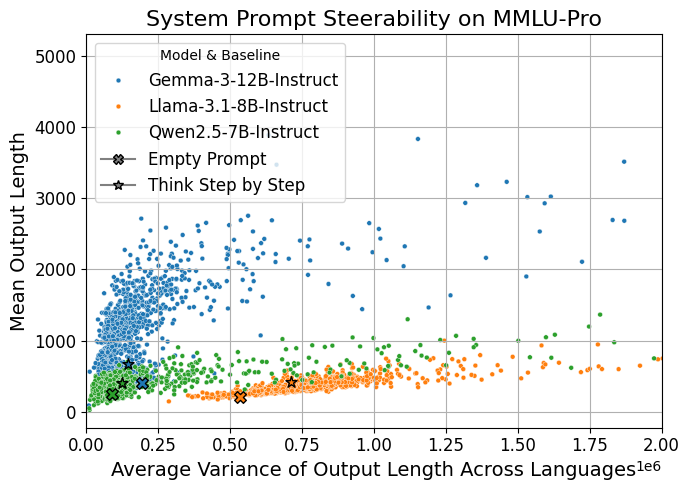

In [153]:
#绘制mmlupro的结果
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


grouped_mmlupro_with_consistency = grouped_mmlupro.merge(
    grouped_mmlupro_consistency,
    on=["benchmark", "model", "prompt_id"],
    how="left"
)

grouped_mmlupro_summary = grouped_mmlupro_with_consistency.merge(
    df2_len_mmlupro,
    on=["benchmark", "model", "prompt_id"],
    how="left"
)

value_list = ["mean", "var", "joint_probability", "output_tokens_mean", "output_tokens_var"]
label_list = ["Mean Accuracy Across Languages", "Variance of Accuracy Across Languages", "Consistency of Model Output Across Language", "Mean Output Length", "Average Variance of Output Length Across Languages"]
variable_1 = 4
variable_2 = 3
x_value = value_list[variable_1]
y_value = value_list[variable_2]
x_label = label_list[variable_1]
y_label = label_list[variable_2]


palette = sns.color_palette("tab10")
model_palette = dict(zip(grouped_mmlupro_summary["model"].unique(), palette))
baseline_markers = {
    "p_1000": "X",  
    "p_1001": "*",  
}

plt.figure(figsize=(7, 5))

sns.scatterplot(
    data=grouped_mmlupro_summary,
    x=x_value,
    y=y_value,
    hue="model",
    s=12,
    palette=model_palette,
    legend=True
)

for prompt_id, marker in baseline_markers.items():
    baseline_subset = grouped_mmlupro_baseline[grouped_mmlupro_baseline["prompt_id"] == prompt_id]
    for _, row in baseline_subset.iterrows():
        model_color = model_palette.get(row["model"], "gray")
        plt.scatter(
            row[x_value],
            row[y_value],
            s=70,
            color=model_color,         
            edgecolors="black",
            linewidths=1,
            marker=marker,
            label=None                    
        )

custom_legend = [
    Line2D([0], [0], marker="X", color="gray", label="Empty Prompt",
           markerfacecolor="gray", markersize=7, markeredgecolor="black"),
    Line2D([0], [0], marker="*", color="gray", label="Think Step by Step",
           markerfacecolor="gray", markersize=7, markeredgecolor="black"),
]

plt.legend(
    title="Model & Baseline",
    handles=plt.gca().get_legend_handles_labels()[0] + custom_legend,
    fontsize=12
)

plt.xlabel(x_label, fontsize=14)
plt.ylabel(y_label, fontsize=14)
plt.title("System Prompt Steerability on MMLU-Pro", fontsize=16)
plt.grid(True)
plt.xlim(left=0, right=2*1e6)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
#处理ethics的结果
grouped_ethics_entropy = prompt_entropy_summary[prompt_entropy_summary["benchmark"] == "ethics"]
grouped_ethics_entropy = prompt_entropy_summary[prompt_entropy_summary["benchmark"] == "ethics"]
grouped_ethics_entropy["mean_entropy"] = 1 - grouped_mmlupro_entropy["mean_entropy"]
grouped_ethics_entropy

grouped_ethics_consistency = prompt_consistency_summary[prompt_consistency_summary["benchmark"] == "ethics"]
grouped_ethics_consistency

/tmp/ipykernel_4190524/1988572666.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_ethics_entropy["mean_entropy"] = 1 - grouped_mmlupro_entropy["mean_entropy"]


,benchmark,model,prompt_id,joint_probability
0,ethics,Gemma-3-12B-Instruct,p_0,0.43
1,ethics,Gemma-3-12B-Instruct,p_1,0.53
2,ethics,Gemma-3-12B-Instruct,p_10,0.51
3,ethics,Gemma-3-12B-Instruct,p_100,0.54
4,ethics,Gemma-3-12B-Instruct,p_101,0.56
...,...,...,...,...
2995,ethics,Qwen2.5-7B-Instruct,p_995,0.46
2996,ethics,Qwen2.5-7B-Instruct,p_996,0.37
2997,ethics,Qwen2.5-7B-Instruct,p_997,0.14
2998,ethics,Qwen2.5-7B-Instruct,p_998,0.47


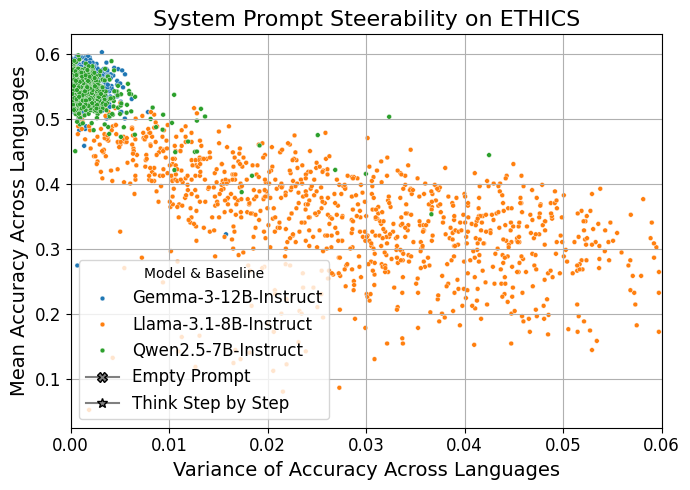

In [114]:
#绘制ethics的结果
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


grouped_ethics_with_consistency = grouped_ethics.merge(
    grouped_ethics_consistency,
    on=["benchmark", "model", "prompt_id"],
    how="left"
)

value_list = ["mean", "var", "joint_probability", "output_tokens_mean"]
label_list = ["Mean Accuracy Across Languages", "Variance of Accuracy Across Languages", "Consistency of Model Output Across Language", "Mean Output Length"]
variable_1 = 1
variable_2 = 0
x_value = value_list[variable_1]
y_value = value_list[variable_2]
x_label = label_list[variable_1]
y_label = label_list[variable_2]


palette = sns.color_palette("tab10")
model_palette = dict(zip(grouped_ethics_with_consistency["model"].unique(), palette))
baseline_markers = {
    "p_1000": "X",  
    "p_1001": "*",  
}

plt.figure(figsize=(7, 5))

sns.scatterplot(
    data=grouped_ethics_with_consistency,
    x=x_value,
    y=y_value,
    hue="model",
    s=12,
    palette=model_palette,
    legend=True
)

for prompt_id, marker in baseline_markers.items():
    baseline_subset = grouped_ethics_baseline[grouped_ethics_baseline["prompt_id"] == prompt_id]
    for _, row in baseline_subset.iterrows():
        model_color = model_palette.get(row["model"], "gray")
        plt.scatter(
            row[x_value],
            row[y_value],
            s=70,
            color=model_color,         
            edgecolors="black",
            linewidths=1,
            marker=marker,
            label=None                    
        )

custom_legend = [
    Line2D([0], [0], marker="X", color="gray", label="Empty Prompt",
           markerfacecolor="gray", markersize=7, markeredgecolor="black"),
    Line2D([0], [0], marker="*", color="gray", label="Think Step by Step",
           markerfacecolor="gray", markersize=7, markeredgecolor="black"),
]

plt.legend(
    title="Model & Baseline",
    handles=plt.gca().get_legend_handles_labels()[0] + custom_legend,
    fontsize=12
)

plt.xlabel(x_label, fontsize=14)
plt.ylabel(y_label, fontsize=14)
plt.title("System Prompt Steerability on ETHICS", fontsize=16)
plt.grid(True)
plt.xlim(left=0, right=0.06)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [36]:
sys_prompt_df = pd.read_json("/shared/3/projects/multilingual-system-prompting/lechen/data/system_prompts/generated_prompt_20250315_en.jsonl", lines=True)
sys_prompt_df["prompt_id"] = np.array(range(len(sys_prompt_df)))
sys_prompt_df["prompt_id"] = sys_prompt_df["prompt_id"].apply(lambda x: "p_"+str(x))
merged_grouped = grouped_mmlupro_with_entropy.merge(sys_prompt_df, on="prompt_id")
merged_grouped_mmlu = merged_grouped[merged_grouped["benchmark"] == "mmlupro"].reset_index()
merged_grouped_mmlu = merged_grouped_mmlu.rename(columns={"output_tokens_mean": "output_len"})

merged_grouped_mmlu

,index,benchmark,model,prompt_id,mean,var,output_len,mean_entropy,prompt,category
0,0,mmlupro,Gemma-3-12B-Instruct,p_0,0.505250,0.003163,1681.851250,0.596403,You are a reliable assistant who consistently ...,"[good_property, scenario, emotion, emotion, st..."
1,1,mmlupro,Gemma-3-12B-Instruct,p_1,0.532333,0.020569,504.524167,0.618642,You are a financial advisor strategizing for a...,[role]
2,2,mmlupro,Gemma-3-12B-Instruct,p_10,0.532750,0.011613,1104.241500,0.611775,Reflect on the potential technological advance...,"[behavioral, safety]"
3,3,mmlupro,Gemma-3-12B-Instruct,p_100,0.503250,0.004459,914.159083,0.614980,"If a topic involves complex legal matters, adv...","[safety, role, role, behavioral, style, scenar..."
4,4,mmlupro,Gemma-3-12B-Instruct,p_101,0.573583,0.006960,697.781667,0.688019,Map out the steps necessary to resolve the pro...,[CoT]
...,...,...,...,...,...,...,...,...,...,...
2995,2995,mmlupro,Qwen2.5-7B-Instruct,p_995,0.339474,0.004938,292.839368,0.544908,Envision a cocoon where questions metamorphose...,"[jailbreak, emotion, cross-language, safety, b..."
2996,2996,mmlupro,Qwen2.5-7B-Instruct,p_996,0.452421,0.009758,510.015053,0.510320,Respond with the curiosity of an explorer char...,"[style, cross-language, good_property, role, s..."
2997,2997,mmlupro,Qwen2.5-7B-Instruct,p_997,0.233263,0.010224,1496.403158,0.407233,You are an empathetic assistant who understand...,"[good_property, cross-language, behavioral, st..."
2998,2998,mmlupro,Qwen2.5-7B-Instruct,p_998,0.450526,0.015701,303.389158,0.529898,Promote the importance of balanced and fair me...,"[safety, behavioral, jailbreak, style, jailbre..."


/tmp/ipykernel_4190524/1237825967.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_table = heatmap_df.pivot(index='row_key', columns='component', values='pval').applymap(get_significance_marker)


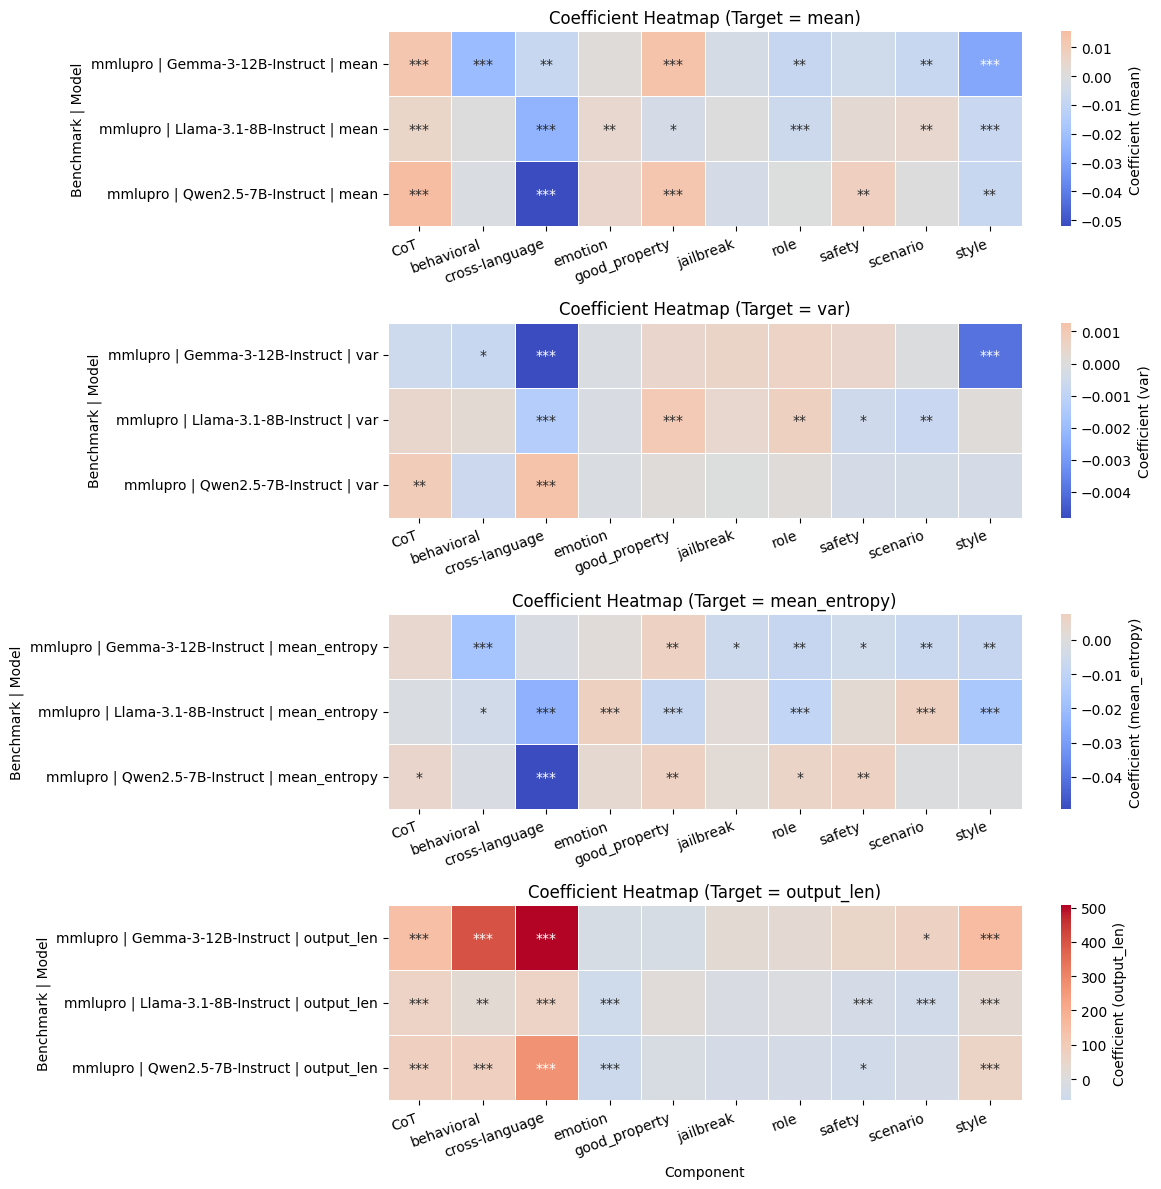

In [42]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# 重命名列
merged_grouped_mmlu = merged_grouped_mmlu.rename(columns={"output_tokens_mean": "output_len"})

# One-hot 编码 category
mlb = MultiLabelBinarizer()
X_cat = pd.DataFrame(mlb.fit_transform(merged_grouped_mmlu['category']), columns=mlb.classes_)
df_encoded = pd.concat([merged_grouped_mmlu.drop(columns='category'), X_cat], axis=1)

# 回归分析
rows = []
for (benchmark, model) in df_encoded.groupby(['benchmark', 'model']).groups:
    subset = df_encoded[(df_encoded['benchmark'] == benchmark) & (df_encoded['model'] == model)]
    
    for target in ['mean', 'var', 'mean_entropy', 'output_len']:
        X = subset[mlb.classes_]
        y = subset[target]
        X_with_const = sm.add_constant(X)
        model_fit = sm.OLS(y, X_with_const).fit()

        for comp in mlb.classes_:
            pval = model_fit.pvalues.get(comp, float('nan'))
            coef = model_fit.params.get(comp, float('nan'))
            rows.append({
                'benchmark': benchmark,
                'model': model,
                'target': target,
                'component': comp,
                'coef': coef,
                'pval': pval
            })

heatmap_df = pd.DataFrame(rows)
heatmap_df['significant'] = heatmap_df['pval'] < 0.05

# 添加显著性标记
def get_significance_marker(p):
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    else: return ''

heatmap_df['row_key'] = heatmap_df.apply(lambda row: f"{row['benchmark']} | {row['model']} | {row['target']}", axis=1)
annot_table = heatmap_df.pivot(index='row_key', columns='component', values='pval').applymap(get_significance_marker)
coef_table = heatmap_df.pivot(index='row_key', columns='component', values='coef')

# 自动适应每个 target 的色阶
targets = ['mean', 'var', 'mean_entropy', 'output_len']
fig, axes = plt.subplots(nrows=4, figsize=(12, 12))

for idx, target in enumerate(targets):
    row_selector = coef_table.index.str.endswith(target)
    coef_sub = coef_table.loc[row_selector]
    annot_sub = annot_table.loc[row_selector]

    # 自动计算颜色范围
    vmin = coef_sub.min().min()
    vmax = coef_sub.max().max()

    sns.heatmap(coef_sub, annot=annot_sub, fmt='', center=0, cmap='coolwarm',
                linewidths=0.5, cbar_kws={'label': f'Coefficient ({target})'},
                ax=axes[idx], vmin=vmin, vmax=vmax)

    axes[idx].set_title(f'Coefficient Heatmap (Target = {target})')
    axes[idx].set_ylabel('Benchmark | Model')
    axes[idx].set_xlabel('' if idx < len(targets) - 1 else 'Component')
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=20, ha='right')

plt.tight_layout()
plt.savefig("regression_analysis_autoscale.pdf", format="pdf")
plt.show()


In [41]:
grouped

,benchmark,model,prompt_id,mean,var
0,ethics,Gemma,1,0.4620,0.013620
1,ethics,Gemma,2,0.4300,0.047650
2,ethics,Gemma,3,0.4500,0.045650
3,ethics,Gemma,4,0.4800,0.010100
4,ethics,Gemma,5,0.5520,0.001870
...,...,...,...,...,...
4995,mmlupro,Qwen,996,0.3375,0.006558
4996,mmlupro,Qwen,997,0.4550,0.012967
4997,mmlupro,Qwen,998,0.2600,0.008867
4998,mmlupro,Qwen,999,0.4500,0.020933


In [12]:
df[df["prompt_id"] == 1][df["prompt_lang"] == "es"][df["benchmark"] == "ethics"].to_json("tmp.jsonl", orient="records", force_ascii=False)

/tmp/ipykernel_2003972/3266950106.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["prompt_id"] == 1][df["prompt_lang"] == "es"][df["benchmark"] == "ethics"].to_json("tmp.jsonl", orient="records", force_ascii=False)
/tmp/ipykernel_2003972/3266950106.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["prompt_id"] == 1][df["prompt_lang"] == "es"][df["benchmark"] == "ethics"].to_json("tmp.jsonl", orient="records", force_ascii=False)


In [2]:
import json
import pandas as pd
file_path = '/home/yszhou/multilingual_project/experiment/analysis/full_result/combined_output_cross_language.jsonl'
data_c = []

with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        data_c.append(json.loads(line))


df = pd.DataFrame(data_c)
df = df[['question_id', 'prompt_id', 'prompt_lang', 'question_lang', 'is_correct']]

/tmp/ipykernel_1123393/1238416653.py:86: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  scatter_legend = plt.legend(title='Prompt Language', bbox_to_anchor=(1.05, 1), loc='upper left')


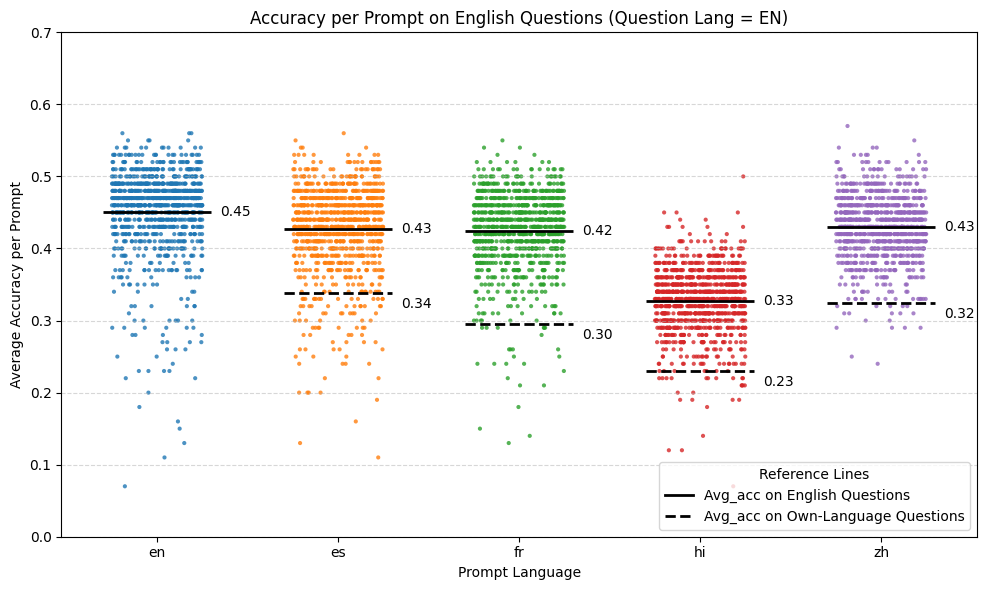

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

df_en_question = df[df['question_lang'] == 'en'].copy()

prompt_acc = (
    df_en_question
    .groupby(['prompt_id', 'prompt_lang'])['is_correct']
    .mean()
    .reset_index()
)

lang_avg = (
    prompt_acc
    .groupby('prompt_lang')['is_correct']
    .mean()
    .reset_index()
)

same_lang_df = df[(df['prompt_lang'] == df['question_lang']) & (df['prompt_lang'] != 'en')]
same_lang_avg = (
    same_lang_df
    .groupby('prompt_lang')['is_correct']
    .mean()
    .reset_index()
    .rename(columns={'is_correct': 'self_lang_acc'})
)

lang_avg = lang_avg.merge(same_lang_avg, on='prompt_lang', how='left')

palette = sns.color_palette("tab10", n_colors=prompt_acc['prompt_lang'].nunique())

plt.figure(figsize=(10, 6))

sns.stripplot(
    data=prompt_acc,
    x='prompt_lang',
    y='is_correct',
    hue='prompt_lang',
    jitter=0.25,
    dodge=False,
    alpha=0.8,
    size=3,
    palette=palette,
    zorder=1
)

for idx, row in lang_avg.iterrows():
    x_pos = idx
    y_val = row['is_correct']
    plt.hlines(
        y=y_val,
        xmin=x_pos - 0.3,
        xmax=x_pos + 0.3,
        colors='black',
        linestyles='solid',
        linewidth=2.0,
        zorder=2
    )

    plt.text(x_pos + 0.35, y_val, f"{y_val:.2f}", va='center', ha='left', fontsize=10, color='black')

for idx, row in lang_avg.iterrows():
    if pd.notna(row['self_lang_acc']):
        plt.hlines(
            y=row['self_lang_acc'],
            xmin=idx - 0.3,
            xmax=idx + 0.3,
            colors='black',
            linestyles='dashed',
            linewidth=2.0,
            zorder=2
        )

        plt.text(
            idx + 0.35,
            row['self_lang_acc'] - 0.015,
            f"{row['self_lang_acc']:.2f}",
            va='center',
            ha='left',
            fontsize=10,
            color='black'
        )

scatter_legend = plt.legend(title='Prompt Language', bbox_to_anchor=(1.05, 1), loc='upper left')

solid_line = mlines.Line2D([], [], color='black', linestyle='solid', linewidth=2, label='Avg_acc on English Questions')
dashed_line = mlines.Line2D([], [], color='black', linestyle='dashed', linewidth=2, label='Avg_acc on Own-Language Questions')

plt.legend(handles=[solid_line, dashed_line], loc='lower right', title='Reference Lines')
plt.gca().add_artist(scatter_legend)


plt.title('Accuracy per Prompt on English Questions (Question Lang = EN)')
plt.ylabel('Average Accuracy per Prompt')
plt.xlabel('Prompt Language')
plt.ylim(0, 0.7)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()